# Partitioning Thresholds in QuASAr

This notebook derives theoretical thresholds for when QuASAr's planner switches simulation methods and introduces circuit partitions.  The estimates are based solely on the calibrated cost model and therefore provide insight into the planner's decisions independent of empirical runtime measurements.

## Methodology

QuASAr incrementally grows a fragment of the input circuit and uses a `MethodSelector` to estimate the cost of running that fragment on the available simulation backends.  Whenever the cheapest backend changes for the extended fragment, the planner finalises the current partition and starts a new one.  The `CostEstimator` exposes analytic runtime and memory models for:

* Dense statevector simulation (`Backend.STATEVECTOR`)
* Stabilizer tableau methods (`Backend.TABLEAU`)
* Matrix product states (`Backend.MPS`)
* Decision diagrams (`Backend.DECISION_DIAGRAM`)

The following sections compare these cost models to highlight cross-over points where a different backend becomes cheaper.  These cross-overs act as theoretical thresholds for partitioning.  Conversion costs between backends are estimated using primitives such as boundary-to-boundary (B2B) extraction and local windows (LW).

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().resolve()
if not (project_root / "quasar").exists():
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from quasar.cost import Backend
import numpy as np
import matplotlib.pyplot as plt

from docs.utils.partitioning_analysis import (
    apply_partitioning_style,
    build_clifford_fragment_curves,
    build_conversion_aware_mps_paths,
    build_conversion_primitive_costs,
    build_partition_plan,
    build_statevector_partition_tradeoff,
    build_statevector_vs_decision_diagram,
    build_statevector_vs_mps,
    export_figure,
    load_calibrated_estimator,
)

estimator, calibration_path = load_calibrated_estimator()
apply_partitioning_style()
if calibration_path:
    print(f"Loaded calibration coefficients from {calibration_path}")
else:
    print("Using built-in CostEstimator defaults (no calibration file found)")


Loaded calibration coefficients from /workspace/QuASAr/calibration/coeff_v1.json


### Tableau vs. Statevector
The tableau simulator handles Clifford-only circuits in \(O(n^2)\) time, whereas dense statevector simulation scales with \(2^n\).  The plot below assumes ten Clifford gates per qubit and shows where the tableau model becomes cheaper.

Tableau becomes cheaper from 12 qubits onwards.


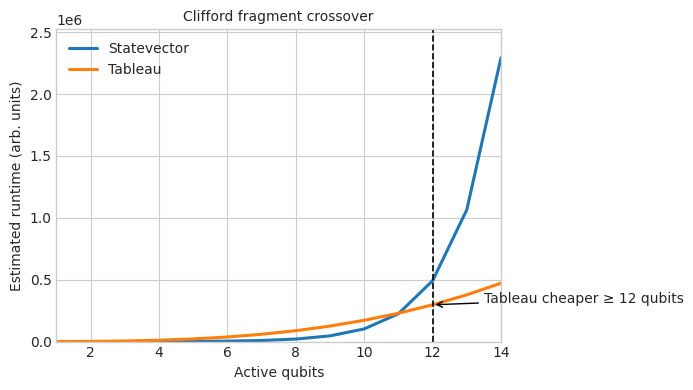

In [2]:
curves = build_clifford_fragment_curves(estimator)
fig, ax = plt.subplots(figsize=(7.0, 4.0))
ax.plot(curves["num_qubits"], curves["statevector"], label="Statevector", linewidth=2.2)
ax.plot(curves["num_qubits"], curves["tableau"], label="Tableau", linewidth=2.2)
ax.set_xlim(curves["num_qubits"][0], curves["num_qubits"][-1])
y_max = float(np.max(np.concatenate((curves["statevector"], curves["tableau"]))))
ax.set_ylim(0, y_max * 1.1)
threshold = curves["threshold"]
if threshold is not None:
    idx = int(np.where(curves["num_qubits"] == threshold)[0][0])
    y_val = curves["tableau"][idx]
    ax.axvline(threshold, color="black", linestyle="--", linewidth=1.2)
    x_text = min(curves["num_qubits"][-1], threshold + 1.5)
    ax.annotate(
        f"Tableau cheaper ≥ {threshold} qubits",
        xy=(threshold, y_val),
        xytext=(x_text, y_val * 1.05),
        arrowprops=dict(arrowstyle="->", linewidth=1.0),
        fontsize=10,
    )
    print(f"Tableau becomes cheaper from {threshold} qubits onwards.")
else:
    print("Tableau path never overtakes statevector in the sampled range.")
ax.set_xlabel("Active qubits")
ax.set_ylabel("Estimated runtime (arb. units)")
ax.set_title("Clifford fragment crossover")
ax.legend(loc="upper left")
fig.tight_layout()
export_figure(fig, "clifford_crossover")
plt.show()

### Conversion overhead context

Statevector and tableau costs cross at different qubit counts, but the planner
rarely switches backends without extracting a boundary first. Quantifying the
extra conversions clarifies when it is still worthwhile to introduce a
partition.

Partitioned execution becomes cheaper from 11 qubits onwards.


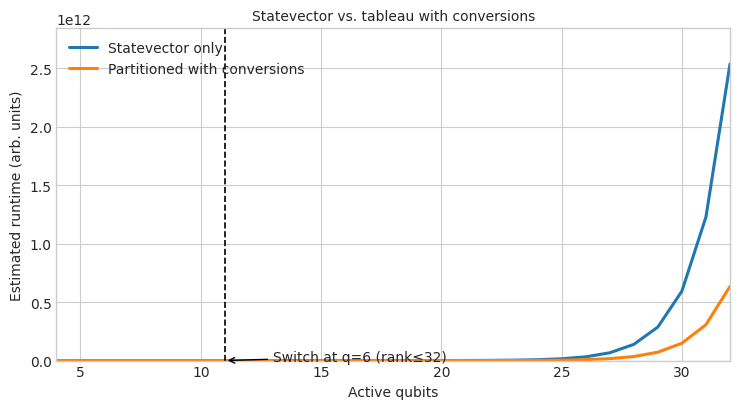

In [3]:
tradeoff = build_statevector_partition_tradeoff(estimator)
fig, ax = plt.subplots(figsize=(7.5, 4.2))
ax.plot(tradeoff["num_qubits"], tradeoff["statevector"], label="Statevector only", linewidth=2.2)
ax.plot(
    tradeoff["num_qubits"],
    tradeoff["partitioned"],
    label="Partitioned with conversions",
    linewidth=2.2,
)
ax.set_xlim(tradeoff["num_qubits"][0], tradeoff["num_qubits"][-1])
y_max = float(np.max(np.concatenate((tradeoff["statevector"], tradeoff["partitioned"]))))
ax.set_ylim(0, y_max * 1.12)
threshold = tradeoff["threshold"]
if threshold is not None:
    idx = int(np.where(tradeoff["num_qubits"] == threshold)[0][0])
    boundary = int(tradeoff["boundary"][idx])
    rank = int(tradeoff["rank"][idx])
    y_val = tradeoff["partitioned"][idx]
    ax.axvline(threshold, color="black", linestyle="--", linewidth=1.2)
    x_text = min(tradeoff["num_qubits"][-1], threshold + 2)
    ax.annotate(
        f"Switch at q={boundary} (rank≤{rank})",
        xy=(threshold, y_val),
        xytext=(x_text, y_val * 1.05),
        arrowprops=dict(arrowstyle="->", linewidth=1.0),
        fontsize=10,
    )
    print(f"Partitioned execution becomes cheaper from {threshold} qubits onwards.")
else:
    print("Partitioned execution is never cheaper in this range.")
ax.set_xlabel("Active qubits")
ax.set_ylabel("Estimated runtime (arb. units)")
ax.set_title("Statevector vs. tableau with conversions")
ax.legend(loc="upper left")
fig.tight_layout()
export_figure(fig, "statevector_tableau_partition")
plt.show()


### Scenario assumptions

- **Gate density.** The circuit starts with two layers of non-Clifford two-qubit
  entanglers and single-qubit phase gates (modelled as `2n` single- and
  `2(n-1)` two-qubit operations). This prefix motivates keeping a dense
  statevector before partitioning. The remaining block contributes
  `6n` single- and `6(n-1)` two-qubit Clifford gates, matching the tableau cost
  estimate.
- **Boundary size.** We convert a six-qubit interface (or the full register if
  it is smaller) representative of a narrow cut between a dense and a Clifford
  partition.
- **Rank/frontier.** The conversion uses a Schmidt-rank cap of 32 and sets the
  decision-diagram frontier equal to the boundary width, reflecting modest
  entanglement at the cut. Adjust these parameters to explore deeper prefixes or
  wider partitions.

### MPS vs. Statevector
For local circuits the matrix-product-state (MPS) backend scales with the bond dimension \(\chi\) instead of \(2^n\).  We assume a linear nearest-neighbour circuit with five single- and two-qubit gates per qubit and \(\chi=4\).

MPS becomes cheaper from 10 qubits onwards.


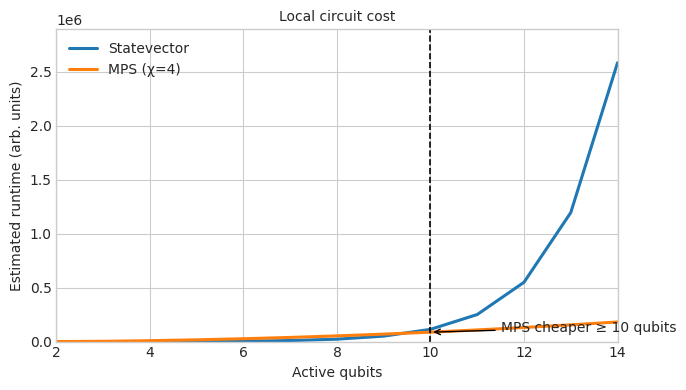

In [4]:
mps_curves = build_statevector_vs_mps(estimator)
fig, ax = plt.subplots(figsize=(7.0, 4.0))
ax.plot(mps_curves["num_qubits"], mps_curves["statevector"], label="Statevector", linewidth=2.2)
ax.plot(mps_curves["num_qubits"], mps_curves["mps"], label="MPS (χ=4)", linewidth=2.2)
ax.set_xlim(mps_curves["num_qubits"][0], mps_curves["num_qubits"][-1])
y_max = float(np.max(np.concatenate((mps_curves["statevector"], mps_curves["mps"]))))
ax.set_ylim(0, y_max * 1.12)
threshold = mps_curves["threshold"]
if threshold is not None:
    idx = int(np.where(mps_curves["num_qubits"] == threshold)[0][0])
    y_val = mps_curves["mps"][idx]
    ax.axvline(threshold, color="black", linestyle="--", linewidth=1.2)
    x_text = min(mps_curves["num_qubits"][-1], threshold + 1.5)
    ax.annotate(
        f"MPS cheaper ≥ {threshold} qubits",
        xy=(threshold, y_val),
        xytext=(x_text, y_val * 1.05),
        arrowprops=dict(arrowstyle="->", linewidth=1.0),
        fontsize=10,
    )
    print(f"MPS becomes cheaper from {threshold} qubits onwards.")
else:
    print("MPS path does not overtake statevector in this range.")
ax.set_xlabel("Active qubits")
ax.set_ylabel("Estimated runtime (arb. units)")
ax.set_title("Local circuit cost")
ax.legend(loc="upper left")
fig.tight_layout()
export_figure(fig, "statevector_vs_mps")
plt.show()


### Folding in conversion overhead
The previous comparison only considered raw simulation time. The next cell layers in the cost of switching between the dense statevector and an MPS fragment via a local window primitive.

MPS path (χ=4, window=6): conversions add 186.00 a.u.; threshold: 10
MPS path (χ=6, window=10): conversions add 186.00 a.u.; threshold: 12


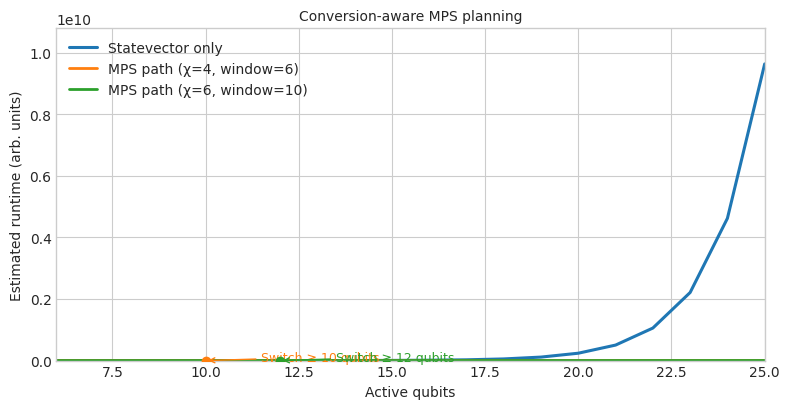

In [5]:
conversion = build_conversion_aware_mps_paths(estimator)
fig, ax = plt.subplots(figsize=(8.0, 4.2))
baseline_line, = ax.plot(
    conversion["num_qubits"], conversion["statevector"], label="Statevector only", linewidth=2.2
)
y_candidates = [conversion["statevector"]]
for scenario in conversion["scenarios"]:
    label = f"MPS path (χ={scenario['chi']}, window={scenario['window']})"
    line, = ax.plot(conversion["num_qubits"], scenario["total"], label=label, linewidth=2.0)
    y_candidates.append(scenario["total"])
    threshold = scenario["threshold"]
    colour = line.get_color()
    if threshold is not None:
        idx = int(np.where(conversion["num_qubits"] == threshold)[0][0])
        y_val = scenario["total"][idx]
        ax.scatter([threshold], [y_val], color=colour, zorder=5)
        x_text = min(conversion["num_qubits"][-1], threshold + 1.5)
        ax.annotate(
            f"Switch ≥ {threshold} qubits",
            xy=(threshold, y_val),
            xytext=(x_text, y_val * 1.05),
            arrowprops=dict(arrowstyle="->", linewidth=1.0, color=colour),
            fontsize=9,
            color=colour,
        )
    conv_time = scenario["sv_to_mps"] + scenario["mps_to_sv"]
    threshold_text = threshold if threshold is not None else "not observed"
    print(
        f"{label}: conversions add {conv_time:.2f} a.u.; threshold: {threshold_text}"
    )
y_max = float(np.max(np.concatenate(tuple(y_candidates))))
ax.set_ylim(0, y_max * 1.12)
ax.set_xlim(conversion["num_qubits"][0], conversion["num_qubits"][-1])
ax.set_xlabel("Active qubits")
ax.set_ylabel("Estimated runtime (arb. units)")
ax.set_title("Conversion-aware MPS planning")
ax.legend(loc="upper left")
fig.tight_layout()
export_figure(fig, "conversion_aware_mps")
plt.show()


The conversion-aware sweep shows that the baseline linear window (\(\chi=4\), six dense qubits) overtakes dense simulation at roughly ten qubits, while a wider, higher-rank window (\(\chi=6\), ten dense qubits) pushes the breakeven out to about twelve.  Larger extraction windows or higher Schmidt ranks amplify conversion overhead, so planners need more register growth before the MPS path becomes preferable.

### Decision Diagram vs. Statevector
Decision diagrams excel on sparse states.  Here we ignore sparsity heuristics and simply compare the cost models for a circuit with ten gates per qubit.

Decision diagrams become cheaper from 1 qubits onwards.


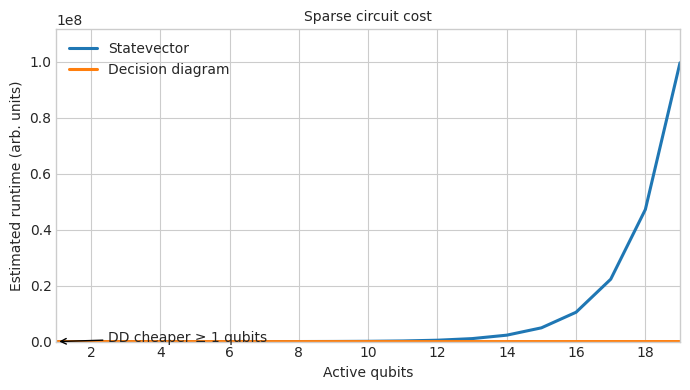

In [6]:
dd_curves = build_statevector_vs_decision_diagram(estimator)
fig, ax = plt.subplots(figsize=(7.0, 4.0))
ax.plot(dd_curves["num_qubits"], dd_curves["statevector"], label="Statevector", linewidth=2.2)
ax.plot(dd_curves["num_qubits"], dd_curves["decision_diagram"], label="Decision diagram", linewidth=2.2)
ax.set_xlim(dd_curves["num_qubits"][0], dd_curves["num_qubits"][-1])
y_max = float(np.max(np.concatenate((dd_curves["statevector"], dd_curves["decision_diagram"]))))
ax.set_ylim(0, y_max * 1.12)
cheaper = dd_curves["decision_diagram"] < dd_curves["statevector"]
if np.any(cheaper):
    idx = int(np.where(cheaper)[0][0])
    threshold = int(dd_curves["num_qubits"][idx])
    y_val = dd_curves["decision_diagram"][idx]
    ax.axvline(threshold, color="black", linestyle="--", linewidth=1.2)
    x_text = min(dd_curves["num_qubits"][-1], threshold + 1.5)
    ax.annotate(
        f"DD cheaper ≥ {threshold} qubits",
        xy=(threshold, y_val),
        xytext=(x_text, y_val * 1.05),
        arrowprops=dict(arrowstyle="->", linewidth=1.0),
        fontsize=10,
    )
    print(f"Decision diagrams become cheaper from {threshold} qubits onwards.")
else:
    print("Decision diagram path never overtakes statevector in this range.")
ax.set_xlabel("Active qubits")
ax.set_ylabel("Estimated runtime (arb. units)")
ax.set_title("Sparse circuit cost")
ax.legend(loc="upper left")
fig.tight_layout()
export_figure(fig, "statevector_vs_decision_diagram")
plt.show()


### Conversion Primitive Selection
When switching between backends, the planner chooses the cheapest conversion primitive.  The example below converts a boundary of size \(q\) from a statevector to a decision diagram and shows which primitive minimises the cost.

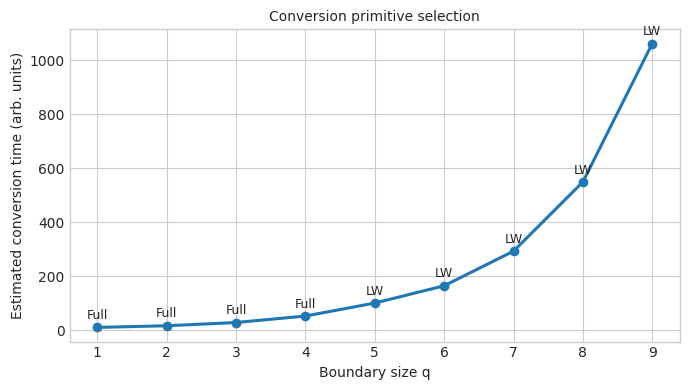

q=1: planner prefers Full (time=11.00 a.u.)
q=5: planner prefers LW (time=101.00 a.u.)


In [7]:
primitive_rows = build_conversion_primitive_costs(estimator)
qs = np.array([row["boundary"] for row in primitive_rows])
times = np.array([row["time"] for row in primitive_rows])
fig, ax = plt.subplots(figsize=(7.0, 4.0))
ax.plot(qs, times, marker="o", linewidth=2.2)
ax.set_xlabel("Boundary size q")
ax.set_ylabel("Estimated conversion time (arb. units)")
ax.set_title("Conversion primitive selection")
ax.set_xticks(qs)
for row in primitive_rows:
    ax.annotate(
        row["primitive"],
        xy=(row["boundary"], row["time"]),
        xytext=(0, 6),
        textcoords="offset points",
        ha="center",
        fontsize=9,
    )
fig.tight_layout()
export_figure(fig, "conversion_primitive_selection")
plt.show()
last_primitive = None
for row in primitive_rows:
    boundary = row["boundary"]
    primitive = row["primitive"]
    time = row["time"]
    if primitive != last_primitive:
        print(f"q={boundary}: planner prefers {primitive} (time={time:.2f} a.u.)")
        last_primitive = primitive


### Multi-fragment staged execution scenario

We consider a 22-qubit workload that naturally splits into three fragments:

| Fragment | Backend | Qubits | 1q gates | 2q gates | Notes |
| --- | --- | --- | --- | --- | --- |
| Clifford prefix | Tableau | 22 | 120 | 50 | Stabiliser-only layers that admit tableau simulation. |
| Non-Clifford core | Statevector | 22 | 90 | 150 | Dense entangling block with high non-Clifford density. |
| Sparse suffix | Decision diagram | 22 | 60 | 30 | Post-processing rotations and checks with a narrow frontier. |

The interfaces between fragments expose moderate boundaries, enabling efficient conversions:

| Boundary | Source → Target | Boundary qubits (q) | Schmidt rank (s) | Frontier (r) | Dense window (w) | Window gates (1q/2q) |
| --- | --- | --- | --- | --- | --- | --- |
| Prefix → core | Tableau → Statevector | 10 | 32 | 18 | 8 | 20 / 15 |
| Core → suffix | Statevector → Decision diagram | 6 | 12 | 8 | 6 | 12 / 8 |


,plan,component,type,backend,primitive,time,memory
0,Single backend,Full circuit (statevector),Simulation,Statevector,,2.774723e+09,9.188025e+07
1,Partitioned,Clifford prefix,Simulation,Tableau,,3.781536e+05,2.780541e+02
2,Partitioned,Non-Clifford core,Simulation,Statevector,,1.379751e+09,9.124729e+07
3,Partitioned,Sparse suffix,Simulation,Decision Diagram,,1.216332e+03,5.189681e+02
4,Partitioned,Prefix → core,Conversion,Tableau→Statevector,Full,6.149000e+03,1.024000e+03
5,Partitioned,Core → suffix,Conversion,Statevector→Decision Diagram,Full,1.970000e+02,6.400000e+01


,total_time,peak_memory
plan,,
Partitioned,1.380136e+09,9.124729e+07
Single backend,2.774723e+09,9.188025e+07


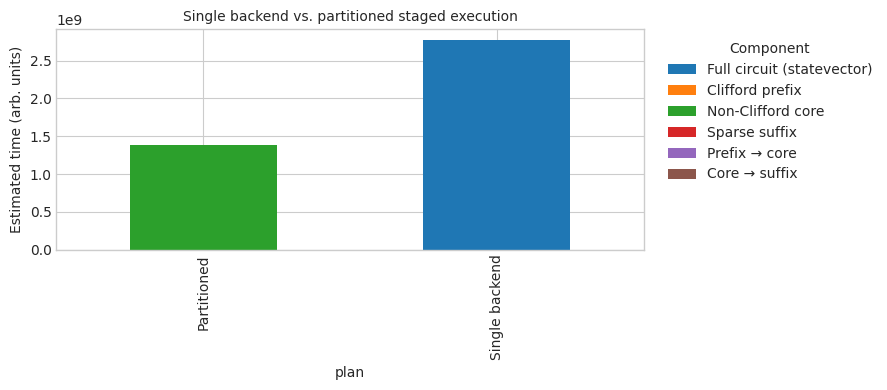

Partitioned plan total time 1380136333.77 a.u. with peak memory 91247290.94; single backend time 2774722746.19 a.u., peak memory 91880249.54.


In [8]:
import pandas as pd
from IPython.display import display

fragments = [
    {
        "name": "Clifford prefix",
        "backend": Backend.TABLEAU,
        "num_qubits": 22,
        "num_1q": 120,
        "num_2q": 50,
        "depth": 18,
    },
    {
        "name": "Non-Clifford core",
        "backend": Backend.STATEVECTOR,
        "num_qubits": 22,
        "num_1q": 90,
        "num_2q": 150,
        "entanglement_entropy": 10.5,
        "rotation_diversity": 0.65,
        "sparsity": 0.15,
    },
    {
        "name": "Sparse suffix",
        "backend": Backend.DECISION_DIAGRAM,
        "num_qubits": 22,
        "num_1q": 60,
        "num_2q": 30,
        "frontier": 8,
        "entanglement_entropy": 4.5,
        "sparsity": 0.7,
        "phase_rotation": 0.1,
        "amplitude_rotation": 0.1,
    },
]

boundaries = [
    {
        "name": "Prefix → core",
        "source": Backend.TABLEAU,
        "target": Backend.STATEVECTOR,
        "num_qubits": 10,
        "rank": 32,
        "frontier": 18,
        "window": 8,
        "window_1q": 20,
        "window_2q": 15,
    },
    {
        "name": "Core → suffix",
        "source": Backend.STATEVECTOR,
        "target": Backend.DECISION_DIAGRAM,
        "num_qubits": 6,
        "rank": 12,
        "frontier": 8,
        "window": 6,
        "window_1q": 12,
        "window_2q": 8,
    },
]

plan = build_partition_plan(
    estimator,
    fragments,
    boundaries,
    total_qubits=22,
    entanglement_entropy=11.5,
    rotation_diversity=0.7,
    sparsity=0.2,
)

records = [
    {
        "plan": "Single backend",
        "component": "Full circuit (statevector)",
        "type": "Simulation",
        "backend": "Statevector",
        "primitive": "",
        "time": plan["single_backend"].time,
        "memory": plan["single_backend"].memory,
    }
]

for frag in plan["fragments"]:
    records.append(
        {
            "plan": "Partitioned",
            "component": frag["name"],
            "type": "Simulation",
            "backend": frag["backend"].name.replace("_", " ").title(),
            "primitive": "",
            "time": frag["cost"].time,
            "memory": frag["cost"].memory,
        }
    )

for conv in plan["conversions"]:
    records.append(
        {
            "plan": "Partitioned",
            "component": conv["name"],
            "type": "Conversion",
            "backend": f"{conv['source'].name.replace('_', ' ').title()}→{conv['target'].name.replace('_', ' ').title()}",
            "primitive": conv["primitive"],
            "time": conv["cost"].time,
            "memory": conv["cost"].memory,
        }
    )

df = pd.DataFrame(records)
summary = df.groupby("plan").agg(
    total_time=("time", "sum"),
    peak_memory=("memory", "max"),
)

display(df)
display(summary)

component_order = []
for rec in records:
    if rec["component"] not in component_order:
        component_order.append(rec["component"])

pivot = df.pivot_table(
    index="plan", columns="component", values="time", aggfunc="sum", fill_value=0
)
pivot = pivot[component_order]

ax = pivot.plot(kind="bar", stacked=True, figsize=(9, 4))
ax.set_ylabel("Estimated time (arb. units)")
ax.set_title("Single backend vs. partitioned staged execution")
ax.legend(title="Component", bbox_to_anchor=(1.02, 1), loc="upper left")
fig = ax.figure
fig.tight_layout()
export_figure(fig, "partition_plan_breakdown")
plt.show()

total_cost = plan["aggregate"]["total_cost"]
print(
    "Partitioned plan total time {:.2f} a.u. with peak memory {:.2f}; "
    "single backend time {:.2f} a.u., peak memory {:.2f}.".format(
        total_cost.time,
        total_cost.memory,
        plan["single_backend"].time,
        plan["single_backend"].memory,
    )
)


The staged plan nearly halves the runtime estimate (1.38e9 vs. 2.77e9 a.u.) while keeping peak memory flat because the tableau prefix and sparse suffix never inflate the dense working set.  Conversions add only 6.3e3 and 1.97e2 a.u., so the savings from isolating the dense non-Clifford core dominate.  Partitioning remains favourable so long as the boundary ranks stay below the quoted limits; if either interface were to balloon in rank or frontier, the full-extraction primitive would erase the advantage.